### Программа подбора графика движения флотов ГРП

#### Модуль версий

In [1]:
### ИСТОРИЯ ВЕРСИЙ
##### v1 - первая рабочая версия.
##### v2 - добавлена задержка на переезд между месторождениями
##### v3 - теперь работаем только с файлом xlsx. Копируем исходный и в него заносим данные. Изменена функция перевода даты в pandas формат
##### v3.1 - 100% рабочая версия
##### v4 - добавлен выбор оптимизация по минимальному времени ожидания флота ГРП (переменная MinMax)
##### v5 - делаем расчет подвесок
##### v6 - добавлен 0 флот для пропуска скважин. Для уменьшения задержки постановки на более высокодебитные
##### v6.1 - добавлена функция дообучения лучшего бота
##### v6.2 - добавлен расчет общей длинны подвесок ГРП
##### v6.3 - скорректирован  расчет подвесок ГРП. К дате вывоза подвески добавлен 1 день, чтобы подвеска считалась занятой в день вывоза. Добавлен расчет по длиннам подвесок. 
##### v6.4 - скорректированы начальные данные в графике ГРП excel. Наведен   порядок. Проведена рзграничение ответсвенности по заполнению.
##### v6.5 - поправлена форма графика в excel (формула расчета стадий). Оптимизирован расчет подвесок ГРП.
##### v7 - для лучшего расчета добавлена сортировка скважин по ЦДНГ
##### v8 - расчет ведется до 30 повторений лучшего значения
##### v8.1 - поправлен вывод об ошибках
##### v9 - добавлена функция дообучения оптимизированного графика ГРП. Изменена функция определения действующих флотов ГРП
##### v9.1 - изменены коэффициенты мутации mutpb с 0.2 до 0.4
##### v9.2 - изменено количество поколений с 500 до 1000  
##### v9.3 - исправлена ошибка при разделении баз - не стирались старые данные по датам ГРП и флотам ГРП
##### v9.4 - изменены гипераметры: cxpb, mutpb, population_size: [0.564308505990577, 0.5791782541293681, 640]
##### v9.5 - изменены гипераметры: cxpb, mutpb, population_size: [cxpb=0.8039690222918632, mutpb=0.1009679312326380, pop=651]
##### v9.6 - гипераметры: cxpb, mutpb, population_size вынесены теперь передаются в функции RunGenereate, optimize_grafik_GRP как аргументы
##### v10 - введен штраф за длинные переезды. Примерно средний дебит умноженный на количество дней в графике ГРП
##### v11 - добавлен расчет ЗР ГРП
##### v12 - добавлен вывод в файл ГТМ УДНГ
##### v12.1 - исправлены баги вывода ГТМ. Добавлена функция пересчета формул в файле ГРП, чтобы потом считать их значения в файл ГТМ
##### v12.2 - исправлены мелкие ошибки в выводе сообщений. Удалены лишние ремарки из кода
##### v12.3 - исправлен баг в функции сохранения файла ГТМ... закрывались все открытые книги excel. Округлены до целых стадии и тонаж ГРП при записи в файл ГТМ... 
##### v12.4 - добавлена функция записи данных в ГТМ без пересчета 

In [1]:
# ПОЯСНЕНИЯ ПО БИБЛИОТЕКЕ DEAP:

# FlotsNumber = "123"

# Эта строка определяет строку символов FlotsNumber, которая содержит только три числа: 1, 2 и 3.
# toolbox.register("attr_int", random.choice, FlotsNumber)

# Здесь мы регистрируем функцию attr_int в нашем toolbox. Эта функция будет использоваться для генерации случайных чисел из строки FlotsNumber. Она возвращает одно случайное число из "123".
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=5)

# Здесь мы регистрируем функцию individual, которая будет создавать одного индивида (или бота). Для создания индивида мы используем функцию tools.initRepeat, которая повторно вызывает функцию toolbox.attr_int n раз (в данном случае 5 раз), чтобы создать список из 5 чисел.
# toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Эта строка регистрирует функцию population, которая создает популяцию индивидов. Эта функция также использует tools.initRepeat, чтобы создать список индивидов.
# toolbox.register("mate", tools.cxTwoPoint)

# Здесь мы регистрируем функцию скрещивания mate, которая использует двухточечное скрещивание (tools.cxTwoPoint). Этот метод скрещивания выбирает две случайные точки в геноме и меняет местами сегменты между этими точками.
# toolbox.register("mutate", tools.mutUniformInt, low=1, up=3, indpb=0.1)

# Регистрация функции мутации mutate. Используется равномерная мутация для целых чисел (tools.mutUniformInt), где каждый атрибут индивида может быть изменен с вероятностью indpb (10% в данном случае). При мутации значение атрибута выбирается случайным образом из диапазона между low и up.
# toolbox.register("select", tools.selTournament, tournsize=3)

# Регистрируем функцию отбора select, которая использует метод турнирного отбора. При этом методе tournsize индивидов случайным образом выбираются из популяции, и наилучший из них (с наилучшим значением приспособленности) выбирается в качестве родителя.
# toolbox.register("evaluate", evaluate)

# Регистрируем функцию оценки evaluate, которая будет использоваться для вычисления приспособленности каждого индивида в популяции.
# def main():

# Это начало функции main, которая будет содержать основной код для выполнения генетического алгоритма.
# pop = toolbox.population(n=300)

# Создаем начальную популяцию из 300 индивидов.
# hof = tools.HallOfFame(1)
# Создаем объект HallOfFame, который будет хранить наилучший индивид (или индивидов) в течение всего процесса генетического алгоритма. Здесь число 1 означает, что будет сохранен только один лучший индивид.
# Этот код создает основные компоненты для генетического алгоритма, включая функции создания индивидов и популяций, операторы скрещивания, мутации и отбора, а также функцию оценки.




# Функция algorithms.eaSimple из библиотеки DEAP представляет собой базовую реализацию простого генетического алгоритма. Рассмотрим каждый аргумент этой функции и его влияние на работу алгоритма:

# pop (population):
# Это начальная популяция, или список индивидуумов, с которого начинается эволюционный процесс. Качество и разнообразие начальной популяции могут существенно повлиять на способность алгоритма находить оптимальные решения.

# toolbox:
# Это инструментарий DEAP, который содержит определения операций генетического алгоритма, таких как скрещивание (crossover), мутация, отбор и функция оценки (fitness evaluation). Настройка этих операций определяет, насколько хорошо алгоритм адаптируется к решению конкретной задачи.

# cxpb (crossover probability):
# Вероятность того, что два индивидуума будут скрещены. Скрещивание - это процесс, в котором дети наследуют гены от двух родителей, что может привести к появлению новых и потенциально более приспособленных индивидуумов. Слишком высокая вероятность может привести к чрезмерному разнообразию, в то время как слишком низкая может замедлить процесс эволюции.

# mutpb (mutation probability):
# Вероятность того, что индивидуум будет подвергнут мутации. Мутация вносит случайные изменения в геномы индивидуумов, способствуя генетическому разнообразию. Как и в случае с вероятностью скрещивания, баланс здесь ключевой: слишком много мутаций может разрушить хорошие решения, а слишком мало - препятствовать исследованию новых областей поискового пространства.

# ngen (number of generations):
# Количество поколений, через которые проходит эволюционный процесс. Это по сути ограничение времени работы алгоритма. Длительный процесс может привести к лучшим результатам, но также требует больше времени для выполнения. Слишком короткий процесс может не успеть достичь оптимального решения.

# stats (statistics):
# Объект, который собирает статистику о процессе эволюции. Это может включать средний фитнес, максимальный/минимальный фитнес и другие метрики. Эта информация полезна для анализа процесса эволюции и оценки эффективности алгоритма.

# halloffame (Hall of Fame):
# Это объект, который хранит лучшие когда-либо найденные решения. Он может быть использован для сохранения лучших индивидуумов во время эволюционного процесса.

# verbose (verbosity):
# Если установлено в True, алгоритм будет выводить дополнительную информацию (например, статистику) на каждом поколении. Это полезно для отслеживания прогресса а

#### Модуль уставки библиотек

In [ ]:
# УСТАНОВКА БИБЛИОТЕК 
# ЧТОБЫ СЧИТАТЬ/СОХРАНИТЬ ФАЙЛ EXCEL 2003 (XLS)
!pip install xlrd
!pip install xlwt 

# модуль для чтения файла excel в формате xlsb
!pip install pyxlsb

# модуль для функции пересчета формул в файле excel
!pip install xlwings

# библиотека генеративного алгоритма
!pip install deap

# библиотека распознования нажатий клавиш
!pip install keyboard

# модуль системных функций. в т.ч. для выхода из программы
# !pip install sys

#### Модуль загрузки библиотек

In [2]:
# ЗАГРУЗКА БИБЛИОТЕК
import xlrd, xlwt       # модули для работы с файлами xls

import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt # Отрисовка изображений
import pandas as pd # Библиотека pandas
import os # Загружаем модуль os для поиска файлов в папках

from datetime import datetime # модуль для расчета разницы в датах
from datetime import timedelta

import random
from deap import base, creator, tools, algorithms
from functools import partial

import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
import pyxlsb
import os
import keyboard

import xlwings as xw  # модуль для функции пересчета формул в файле excel

import time

# модуль системных функций. в т.ч. для выхода из программы
import sys

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

In [3]:
# команда для вывода ВСЕХ столбцов в pandas
pd.set_option('display.max_columns', None)
#Для строк:
#pd.set_option('display.max_rows', None)

#pd.set_option('display.expand_frame_repr', True)  #для отображения большого обьема без переносов

#!!!!!! Сбросить все настойки на дефолт !!!!!!!
#pd.reset_option('all')
#-----------------------------------------------------------------------------

#### Модуль функций создания копий файлов

In [3]:
# копируем файл "ГрафикГРП" в новый "ГрафикГРП(оптимизированный)"
def CopyGrafikGRP(FName):
    source_file = basePath + FName
    copy_file = source_file.replace(".xlsx", "_(оптимизированный).xlsx")
        
    # Если файл-копия уже существует, удаляем его
    if os.path.exists(copy_file):
        os.remove(copy_file)
    os.system(f'copy "{source_file}" "{copy_file}"')
    return(copy_file)

In [4]:
# копируем файл "ГТМ УДНГ" в новый "ГТМ УДНГ(оптимизированный)"
def CopyGrafikGTM(GTMfname):
    GTM_source_file = basePath + GTMfname
    GTM_copy_file = GTM_source_file.replace(".xlsx", "_(оптимизированный).xlsx")
    # Если файл-копия уже существует, удаляем его
    if os.path.exists(GTM_copy_file):
        os.remove(GTM_copy_file)
    os.system(f'copy "{GTM_source_file}" "{GTM_copy_file}"')
    return(GTM_copy_file)

#### Модуль функций записи файлов ГТМ excel

In [29]:
# МОДУЛЬ СОХРАНЕНИЯ ДАННЫХ В ФАЙЛЕ ГТМ

# функия пересчета формул в excel для корректного считывания значений формул-------------------
def recalculate_excel(file_path):
    # Открыть книгу Excel
    book = xw.Book(file_path)
    
    try:
        # Установить режим отображения Excel на False для ускорения процесса
        book.app.screen_updating = False

        # Пересчитать все формулы в книге
        book.app.calculate()

        # Сохранить изменения
        book.save()
        # Установить режим отображения Excel на True, иначе перестанут быть видными все открытые книги 
        book.app.screen_updating = True        

    finally:
        # Закрыть только эту книгу Excel
        book.close() 
#-----------------------------------------------------------------------------------------------
        
# Функция записи данных в файл ГТМ--------------------------------------------------------------
def GTMwrite (GTMdf, firstrow, columnlist, sheet):
    # Обновите значения на листе
    for idx, r in enumerate(dataframe_to_rows(GTMdf, index=False, header=False), start=firstrow):
        for c_idx, value in enumerate(r):  # начните с 2, чтобы начать с колонки B
#             print(c_idx)
#             print("",columnlist[c_idx])
            sheet.cell(row=idx, column=columnlist[c_idx], value=value)
#----------------------------------------------------------------------------------------------

#--------функци записи данных из графика ГРП в файл ГТМ-----------------------------------------
def GTMriteFile (copy_file):
    
    # Пересчитываем формулы на листе для корректного считывания в pandas
    recalculate_excel(copy_file)
    
    # читаем в датафрейм график с уже посчитанными датами окончания ЗР ГРП
    print("Читаем файл ",copy_file)
    gGRP1=pd.read_excel(copy_file, sheet_name='График ГРП', usecols="B:AQ", index_col=None,  skiprows=skiprs, nrows=rowsread)
    
    
    
    gGRP1.DateKonZr.notnull().sum()
    
    gGRP1 = gGRP1.dropna(subset=['SKV'])   #удалем строки с пустыми значениями №СКВ, №КУСТ 
    gGRP1 = gGRP1.dropna(subset=['KUST'])
    gGRP1 = gGRP1[gGRP1.DateKonZr.notnull()] #удалем строки с пустыми значениями в дате ЗР ГРП 
    
    # переводим все даты в дату пандас
    gGRP1.DateNachZr=pd.to_datetime(gGRP1.DateNachZr)
    gGRP1.DateKonZr=pd.to_datetime(gGRP1.DateKonZr)
    gGRP1.DatePozOsv=pd.to_datetime(gGRP1.DatePozOsv)
    gGRP1.DateNachGRP=pd.to_datetime(gGRP1.DateNachGRP)
    gGRP1.DateKonGRP=pd.to_datetime(gGRP1.DateKonGRP)
    
    
    # В этом коде метод apply используется для применения функции ко всем строкам датафрейма. 
    # Лямбда-функция внутри apply использует f-строки для формирования строки для каждой строки датафрейма, 
    # объединяя значения столбцов Nstadiy, Tn_prop_stad, и TypeGRP.
    
    # создание столбца МЕРОПРИЯТИЯ в формате "ГРП 1ст.x30т (Стандарт)"
    gGRP1['MEROPR'] = gGRP1.apply(lambda row: f"ГРП {int(row.Nstadiy)}ст. x {int(row.Tn_prop_stad)}т ({row.TypeGRP})" + 
        (f" (2A габарит)" if row['2Agabarit'] == 1 else ""), axis=1)
    
    # создание столбца примечание в формате ОП-12.08/ГРП 01.12-04.12 /ПС-1
    gGRP1['PRIM'] = gGRP1.apply(
        lambda row: f"ОП-" + 
        (row.DatePozOsv.strftime('%d.%m') if pd.notna(row.DatePozOsv) else 'н/д') + 
        " / ГРП " +
        (row.DateNachGRP.strftime('%d.%m') if pd.notna(row.DateNachGRP) else 'н/д') +
        "-" +
        (row.DateKonGRP.strftime('%d.%m') if pd.notna(row.DateKonGRP) else 'н/д') +
        f" / {row.FlotNumber}", axis=1)
    
    # запись данных в файл ГТМ УДНГ
    cols=['SKV','KUST','MEST','CDNG','Qn_ozid','Qz_ozid','H2O_ozid','MEROPR','DateNachPR','DateKonZr','PRIM','KV_OD']
    GTMbase=gGRP1[cols]
    
    GTMrows={'ВНС':8,'ОД':41,'ЗБС':104}        # номера строк в файле ГТМ
    GTMcols=[2,3,4,5,13,14,15,28,34,35,54,62]  # номера столбцов в файле ГТМ соответсвующие столбцам из GTMbase
    
    # Загрузите файл
    book = openpyxl.load_workbook(GTM_copy_file)
    # Получите нужный лист
    sheet = book[GTMsheetname]
    
    for vidgtm in GTMrows.keys():
    #     tempdf=GTMbase[(GTMbase.KV_OD==vidgtm) & (GTMbase.DateKonZr.notnull())] # копируем во временную базу отдельные фреймы по ВНС, ЗБС, ОД (ГРП)
        tempdf=GTMbase[GTMbase.KV_OD==vidgtm] # копируем во временную базу отдельные фреймы по ВНС, ЗБС, ОД (ГРП)
        GTMwrite(tempdf, GTMrows[vidgtm], GTMcols, sheet)   
      
    
                
    # Сохраняем изменения
    print("Сохраняем файл: ",GTM_copy_file )
    book.save(GTM_copy_file)
    book.close()

#### Инициация переменных. Определение начальных действий с файлами

In [7]:
# ИНИЦИАЦИЯ ПЕРЕМЕННЫХ
#путь к файлу графика ГРП

basePath ='./'
GTMfname="ГТМ_УДНГ_ГРП.xlsx"
GTMsheetname="Мер_расч_мес"

skiprs=17                   # количество строк пропускаем при считывании листа ГРП
rowsread=200                   # количество строк которые считываем

# ЕСЛИ НАДО ПРОСТО ЕПЕРЕПИСЫВАЕМ ДАННЫЕ ИЗ ГРАФИКА ГРП (оптимизированный) в ГТМ
k=""
print ("\nХотите просто переписать данные в ГРАФИК_ГТМ? \nЕсли ДА нажмите Y, если НЕТ нажмите N")
k = keyboard.read_key()
# print(k)
if k in "yYнН": 
    FName ="График_ГРП_(оптимизированный).xlsx"
    GTM_copy_file = CopyGrafikGTM(GTMfname)
    print("======= Переписываем данные из файла ", FName, ' файл ГТМ =========')
    copy_file ="График_ГРП_(оптимизированный).xlsx"
    GTMriteFile (copy_file)
    time.sleep(1)
    sys.exit()

# Спрашиваем с каким графиком работать
# Или с нуля строим график из файла График_ГРП.xlsx
# Или оптимизируем файл График_ГРП_(оптимизированный).xlsx
time.sleep(0.3)
print ("\nРаботаем с оптимизированным графиком ГРП? \nЕсли ДА нажмите Y, если НЕТ нажмите N")
k = keyboard.read_key()
if k in "yYнН": 
    print("====== Работаем с оптимизированным графиком =====")
    FName ="График_ГРП_(оптимизированный).xlsx"
    Doobuchenie=True

else:
    FName ="График_ГРП.xlsx"
    print("\nСоставляем график ГРП с нуля")
    Doobuchenie=False

copy_file = CopyGrafikGRP(FName)
GTM_copy_file = CopyGrafikGTM(GTMfname)

# Открываем рабочую книгу
wb = openpyxl.load_workbook(basePath+FName)
ws = wb['График ГРП']       # Выбираем рабочий лист (например, первый)

FirstDate = ws['A13'].value # Считываем первый день месяца для расчета накопленного дебита 
LastDate = ws['A14'].value  # Считываем последний день месяца для расчета накопленного дебита
FlotsNumber=ws['A15'].value # количество флотов
MinMaxcell=ws['A16'].value  # тип оптимизатора Min или Max
MaxGen=ws['A17'].value      # количество генераций поколений
PereezdStraf=ws['A18'].value  # штраф за переезд между далекими месторождениями примерно приниимаем на уровне среднего дебита
PereezdStraf=PereezdStraf * (LastDate - FirstDate).days  # для повышения веса штрафа умножаем на период расчета графика

BestCount=30                # количество повторений лучшего значения при котором алгоритм остановится

wb.close()                  # Закрываем рабочую книгу



Хотите просто переписать данные в ГРАФИК_ГТМ? 
Если ДА нажмите Y, если НЕТ нажмите N

Работаем с оптимизированным графиком ГРП? 
Если ДА нажмите Y, если НЕТ нажмите N

Составляем график ГРП с нуля


In [8]:
# считываем график из excel
print()
print("Считываем файл: ",FName)

gGRP=pd.read_excel(basePath + FName, sheet_name='График ГРП', usecols="B:AQ", index_col=None,  skiprows=skiprs, nrows=rowsread)

gGRP = gGRP.dropna(subset=['SKV'])   #удялем строки с пустыми значениями №СКВ, №КУСТ 
gGRP = gGRP.dropna(subset=['KUST'])

gGRP_Back=gGRP.copy() # копия на случай тренировок

# считываем таблицу со временем переезда между ЦДНГ
PereezdTimeBase=pd.read_excel(basePath + FName, sheet_name='переезды', usecols="A:K", index_col="ЦДНГ",  skiprows=0)
# PereezdTimeBase[1][1]

# PodvGRPgrapf=pd.read_excel(basePath + FName, sheet_name='подвески', usecols="A:S", index_col="PodvGRP",  skiprows=0)

# print(PereezdTimeBase)
# print()
# print(PodvGRPgrapf)
# print()

print(gGRP.shape)
gGRP.head(5)


Считываем файл:  График_ГРП.xlsx
(61, 42)


,CDNG,MEST,SKV,KUST,PLAST,KATEG,2Agabarit,DopRaboti,Kvaznost,Qn_nak_ozid,...,Nstadiy,Tn_prop_stad,Time_stad,TimeGRP,14,15,16,17,18,FlotNumber
0,3,Вахское,1440,38,Ю1(2+3),нефт,NaN,NaN,1.0,NaN,...,1.0,50.0,24.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,7,Ломовое,708,24,Ю1(1+2+м),нефт,NaN,NaN,5.0,NaN,...,4.0,25.0,21.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Вахское,1043,55,Ю1/2+3,нефт,NaN,1.0,5.0,NaN,...,3.0,40.0,22.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Советское,830,76,АВ1,нефт,NaN,1.5,3.0,NaN,...,5.0,5.0,24.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
4,3,Вахское,557,41,Б16-20,нефт,1.0,2.0,1.0,NaN,...,1.0,30.0,22.0,1.0,NaN,NaN,NaN,NaN,NaN,ПС-1


In [ ]:
# !!!!! Пропускаем если все по плану !!!!
gGRP=gGRP_Back.copy()

In [9]:
# Переводим даты из формата excel в формат pandas 

# !!! ТОЛЬКО ДЛЯ ФАЙЛА XLSB !!!!!!!!!!
# 25569 - разница между Excel и unix (1900-01-01 и 1970-01-01)
#gGRP.DateGotGRP = pd.to_datetime(gGRP.DateGotGRP-25569, unit='D')
#gGRP.DateNachGRP = pd.to_datetime(gGRP.DateNachGRP-25569, unit='D')
#gGRP.DateKonGRP = pd.to_datetime(gGRP.DateKonGRP-25569, unit='D')
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Переводим даты из формата excel в формат pandas !!!
gGRP.DateGotGRP = pd.to_datetime(gGRP.DateGotGRP)
gGRP.DateNachGRP = pd.to_datetime(gGRP.DateNachGRP)
gGRP.DateKonGRP = pd.to_datetime(gGRP.DateKonGRP)

# переводим нужные данные в число
gGRP.Qn_ozid = gGRP.Qn_ozid.apply(int)
gGRP.Nstadiy = gGRP.Nstadiy.apply(int)
gGRP.Tn_prop_stad = gGRP.Tn_prop_stad.apply(int)
gGRP.Time_stad = gGRP.Time_stad.apply(int)
gGRP.TimeGRP = gGRP.TimeGRP.apply(int)

# переводим некоторые значения в текст
# gGRP.FlotNumber = gGRP.FlotNumber.apply(str)

# Добавляем столбец с расчетом максимально возможного накопленного дебита 
gGRP["QnMAX"]=((LastDate-gGRP["DateKonGRP"]).dt.days-gGRP["TimeGRP"])*gGRP["Qn_ozid"]

print(gGRP.shape)


(61, 43)


In [10]:
# модуль проверок пустых значений в ЦДНГ, ДатеГотовности к ГРП, Qн
if gGRP.CDNG.isnull().any():
    print ("Не во всех строка указан номер ЦДНГ")
    keyboard.read_key()
    exit()
    
if gGRP.DateGotGRP.isnull().any():
    print ("Не во всех строках указана дата готовности к ГРП")
    keyboard.read_key()
    exit()

if gGRP.Qn_ozid.isnull().any():
    print ("Не во всех строках указан ожидаемый дебит нефти")
    keyboard.read_key()
    exit()

if gGRP.Kvaznost.isnull().any():
    print ("Не во всех строках указан коэффициент важности скважины. от 1 - самый низкий, 100 - самый высокий")
    keyboard.read_key()
    exit()

In [11]:
# ищем и копируем в ActiveGRP строки из базы gGRP где сейчас стоят флота ГРП

# для корректной работы еще раз переовдим DateKonGRP в дату пандас
gGRP['DateKonGRP'] = pd.to_datetime(gGRP['DateKonGRP'])

# Находим минимальные значения для каждой группы в 'DateKonGRP' и уникальные в FlotNumber
grouped = gGRP.groupby('FlotNumber')['DateKonGRP'].idxmin()

# Получаем номера строк, удовлетворяющих условию
rows_to_keep = grouped.values

# Создаем ActiveGRP, содержащий строки, удовлетворяющие условию
ActiveGRP = gGRP.loc[rows_to_keep]

# удаляем из gGRP строки, удовлетворяющие условию
gGRP = gGRP.drop(rows_to_keep)

# очищаем даты начала окончания ГРП
gGRP.DateNachGRP=pd.NaT
gGRP.DateKonGRP=pd.NaT

print(f"gGRP.shape {gGRP.shape}")
print(f"ActiveGRP.shape {ActiveGRP.shape}")

ActiveGRP

gGRP.shape (58, 43)
ActiveGRP.shape (3, 43)


,CDNG,MEST,SKV,KUST,PLAST,KATEG,2Agabarit,DopRaboti,Kvaznost,Qn_nak_ozid,...,Tn_prop_stad,Time_stad,TimeGRP,14,15,16,17,18,FlotNumber,QnMAX
4,3,Вахское,557,41,Б16-20,нефт,1.0,2.0,1.0,NaN,...,30,22,1,NaN,NaN,NaN,NaN,NaN,ПС-1,651.0
24,1,Советское,1835,168,АВ1,нефт,NaN,NaN,3.0,NaN,...,7,24,5,NaN,NaN,NaN,NaN,NaN,ПС-17,1740.0
40,3,Вахское,1395,37,Ю1/1,нефт,NaN,NaN,1.0,658.0,...,40,22,1,NaN,NaN,NaN,NaN,NaN,ПС-18,644.0


In [12]:
# сортируем по дате готовности к ГРП
# gGRP=gGRP.sort_values(by='DateGotGRP', ascending=True)
gGRP=gGRP.sort_values(by=['DateGotGRP','CDNG','Qn_ozid'], ascending=[True,True,False])

gGRP.head(10)

,CDNG,MEST,SKV,KUST,PLAST,KATEG,2Agabarit,DopRaboti,Kvaznost,Qn_nak_ozid,...,Tn_prop_stad,Time_stad,TimeGRP,14,15,16,17,18,FlotNumber,QnMAX
6,7,Катыльгинское,670Б,12,Ю1(1),нефт,NaN,NaN,5.0,2322.0,...,14,21,4,NaN,NaN,NaN,NaN,NaN,ПС-1,NaN
41,1,Советское,642,21,БВ0,нефт,NaN,NaN,1.0,880.0,...,5,30,4,NaN,NaN,NaN,NaN,NaN,ПС-18,NaN
25,2,Нижневартовское,1292,39,АВ1,нефт,NaN,NaN,3.0,1246.0,...,7,24,3,NaN,NaN,NaN,NaN,NaN,ПС-17,NaN
42,3,Вахское,161,20,Ю1/1+2+3,нефт,NaN,NaN,1.0,1032.0,...,100,33,1,NaN,NaN,NaN,NaN,NaN,ПС-18,NaN
43,3,Вахское,877,32,Ю1/1+2+3,нефт,NaN,NaN,1.0,595.0,...,100,33,1,NaN,NaN,NaN,NaN,NaN,ПС-18,NaN
44,3,Вахское,1362,36Б,Ю1,нефт,NaN,NaN,1.0,504.0,...,50,24,1,NaN,NaN,NaN,NaN,NaN,ПС-18,NaN
26,1,Советское,532,52,АВ1,нефт,NaN,NaN,3.0,1230.0,...,5,24,5,NaN,NaN,NaN,NaN,NaN,ПС-17,NaN
7,2,Советское,2225,234,АВ1,нефт,1.0,NaN,1.0,820.0,...,7,30,3,NaN,NaN,NaN,NaN,NaN,ПС-1,NaN
27,2,Советское,883,82,АВ1,нефт,NaN,NaN,3.0,1540.0,...,5,24,5,NaN,NaN,NaN,NaN,NaN,ПС-17,NaN
8,1,Советское,10012,91,АВ1,нефт,NaN,NaN,3.0,2250.0,...,5,24,7,NaN,NaN,NaN,NaN,NaN,ПС-1,NaN


In [13]:
# преобразуем название действующих флотов в список
FlotsName=ActiveGRP["FlotNumber"].tolist()

# копируем в аналогичный список даты окончания ГРП
ActiveGRPend=ActiveGRP["DateKonGRP"].tolist()

# копируем в список номера ЦДНГ по текущим скважинам
ActiveGRPcdng=ActiveGRP["CDNG"].tolist()

tempGRPend=ActiveGRPend.copy()
tempGRPcdng=ActiveGRPcdng.copy()

print()
print("Начинаю оптимизацию графика: ", FName)
print("Пока я работаю, можете выпить кофе.")
print()
# print(FlotsName)
# print(ActiveGRPend)
# print(ActiveGRPcdng)


Начинаю оптимизацию графика:  График_ГРП.xlsx
Пока я работаю, можете выпить кофе.



In [14]:
# тренировка - проверка корректности расчета переезда между месторождениями
bot=[1,2,3]
for i in range(0,len(bot)): 
       
    d=int(gGRP["TimeGRP"].iloc[i])                                        # время проведения ГРП на скважине
        
    CDNGactive=int(gGRP["CDNG"].iloc[i])                                  # номер ЦДНГ текущей скважины
    CDNGlast=tempGRPcdng[bot[i]-1]                                        # номер ЦДНГ прошлой скважины
    TimePereezd=PereezdTimeBase[CDNGlast][CDNGactive]                     # время переезда между ЦДНГ (сут)
    print ("время переезда между ЦДНГ", CDNGlast, " и ", CDNGactive, " = ", TimePereezd, " суток " )

время переезда между ЦДНГ 3  и  7  =  3  суток 
время переезда между ЦДНГ 1  и  1  =  0  суток 
время переезда между ЦДНГ 3  и  2  =  1  суток 


In [14]:
# ФУНКЦИЯ РАСЧЕТА ОШИБКИ в 2-х вариантах.  MAX - максимальный накопленный дебит. MIN - минимальное время ожидания флота
def evaluate (individual, mm):           # функция  расчета максимального дебита от графика ГРП
    bot=individual
    QnTemp=0                             # начальный накопленный дебит нефти
    tempGRPend=ActiveGRPend.copy()       # заносим во времененную перменную даты окочания ГРП по рвущимся скважинам
    tempGRPcdng=ActiveGRPcdng.copy()     # заносим во времененную перменную номера ЦДНГ по рвущимся скважинам
    #tempGRPbegin=tempGRPend[0]
    
# цикл расчета накопленного дебита для данного графика флотов ГРП
    for i in range(0,len(bot)): 
            if bot[i]!=0:         # если номер флота не равен 0 то запускаем просчет ошибки 
            
                d=int(gGRP["TimeGRP"].iloc[i])                                        # время проведения ГРП на скважине

                CDNGactive=int(gGRP["CDNG"].iloc[i])                                  # номер ЦДНГ текущей скважины
                CDNGlast=tempGRPcdng[bot[i]-1]                                        # номер ЦДНГ прошлой скважины
                TimePereezd=PereezdTimeBase[CDNGlast][CDNGactive]                     # время переезда между ЦДНГ (сут)


        #       если дата готовности скважины к ГРП, позже даты освобождения флота
        #       начальной датой ГРП берем дату готовности СКВАЖИНЫ к ГРП
        #       в противном случай датой начала ГРП будет дата ОСВОБОЖДЕНИЯ ФЛОТА
                if gGRP["DateGotGRP"].iloc[i] < tempGRPend[bot[i]-1]:
                    tempGRPbegin=tempGRPend[bot[i]-1]
                    tempGRPend[bot[i]-1] = tempGRPbegin + timedelta(days=d + int(TimePereezd))       # обновляем дату готовности к ГРП флота bot[i]
                else:
                    tempGRPbegin=gGRP["DateGotGRP"].iloc[i]
                    tempGRPend[bot[i]-1] = tempGRPbegin + timedelta(days=d + int(TimePereezd)) # обновляем дату готовности к ГРП флота bot[i]

                if mm == "Max":
                    # добавляем накопленную добычу с учетом коэффициента важности скважины
                    QnTemp+= (LastDate-tempGRPend[bot[i]-1]).days * gGRP["Qn_ozid"].iloc[i] * gGRP["Kvaznost"].iloc[i] \
                                + TimePereezd * -PereezdStraf    # штраф за далекий переезд
                                                          
                elif mm == "Min":
                    #суммируем минимальное время ожидания флота коэффициента важности скважины
                    timeD = tempGRPbegin - gGRP["DateGotGRP"].iloc[i]
                    QnTemp+= abs(timeD.days) + (-gGRP["Qn_ozid"].iloc[i] * gGRP["Kvaznost"].iloc[i] \
                                + TimePereezd * PereezdStraf)    # штраф за далекий переезд
                             
                            
                tempGRPcdng[bot[i]-1]=CDNGactive                               # обновляем номер ЦДНГ для текущего флота  
    return(QnTemp,)

In [15]:
# ФУНКЦИЯ ЗАПИСИ ЛУЧШЕГО БОТА В ДАТА ФРЕЙМ gGRP
def bestbotsave (individual, mm):           
    bot=individual
    QnTemp=0                             # начальный накопленный дебит нефти
    tempGRPend=ActiveGRPend.copy()       # заносим во времененную перменную даты окочания ГРП по рвущимся скважинам
    tempGRPcdng=ActiveGRPcdng.copy()     # заносим во времененную перменную номера ЦДНГ по рвущимся скважинам
    #tempGRPbegin=tempGRPend[0]
    
# цикл расчета накопленного дебита для данного графика флотов ГРП
    for i in range(0,len(bot)): 
            if bot[i]!=0:         # если номер флота не равен 0 то просчет ошибки запускаем
            
                d=int(gGRP["TimeGRP"].iloc[i])                                        # время проведения ГРП на скважине

                CDNGactive=int(gGRP["CDNG"].iloc[i])                                  # номер ЦДНГ текущей скважины
                CDNGlast=tempGRPcdng[bot[i]-1]                                        # номер ЦДНГ прошлой скважины
                TimePereezd=PereezdTimeBase[CDNGlast][CDNGactive]                     # время переезда между ЦДНГ (сут)


        #       если дата готовности скважины к ГРП, позже даты освобождения флота
        #       начальной датой ГРП берем дату готовности СКВАЖИНЫ к ГРП
        #       в противном случай датой начала ГРП будет дата ОСВОБОЖДЕНИЯ ФЛОТА
                if gGRP["DateGotGRP"].iloc[i] < tempGRPend[bot[i]-1]:
                    tempGRPbegin=tempGRPend[bot[i]-1]
                    tempGRPend[bot[i]-1] = tempGRPbegin + timedelta(days=d + int(TimePereezd))       # обновляем дату готовности к ГРП флота bot[i]
                else:
                    tempGRPbegin=gGRP["DateGotGRP"].iloc[i]
                    tempGRPend[bot[i]-1] = tempGRPbegin + timedelta(days=d + int(TimePereezd)) # обновляем дату готовности к ГРП флота bot[i]

                if mm == "Max":
                    # добавляем накопленную добычу с учетом коэффициента важности скважины
                    QnTemp+= (LastDate-tempGRPend[bot[i]-1]).days * gGRP["Qn_ozid"].iloc[i] * gGRP["Kvaznost"].iloc[i] \
                                + TimePereezd * -PereezdStraf    # штраф за далекий переезд
                                                          
                elif mm == "Min":
                    #суммируем минимальное время ожидания флота коэффициента важности скважины
                    timeD = tempGRPbegin - gGRP["DateGotGRP"].iloc[i]
                    QnTemp+= abs(timeD.days) + (-gGRP["Qn_ozid"].iloc[i] * gGRP["Kvaznost"].iloc[i] \
                                + TimePereezd * PereezdStraf)    # штраф за далекий переезд
                
                tempGRPcdng[bot[i]-1]=CDNGactive                               # обновляем номер ЦДНГ для текущего флота  
            
                #gGRP["FlotNumber"].iloc[i]=bot[i]  # обновляем номер флота для скважины gGRP["SKV"].iloc[i]
                gGRP["FlotNumber"].iloc[i]=FlotsName[bot[i]-1]  # обновляем номер флота для скважины gGRP["SKV"].iloc[i]
                gGRP["DateKonGRP"].iloc[i]=tempGRPend[bot[i]-1] # обновляем дату окончания ГРП для скважины gGRP["SKV"].iloc[i]
                gGRP["DateNachGRP"].iloc[i]=tempGRPend[bot[i]-1]-timedelta(days=d) # обновляем дату начала ГРП для скважины gGRP["SKV"].iloc[i]
                gGRP["Qn_nak_ozid"].iloc[i]=(LastDate-tempGRPend[bot[i]-1]).days*gGRP["Qn_ozid"].iloc[i] # добавляем накопленную добычу

                gGRP["PereezdTime"].iloc[i] = TimePereezd    # добавляем время переезда
           
    return(QnTemp,)

In [16]:
# ФУНКЦИЯ ЗАПУСКА ГЕНЕТИЧЕСКОГО АЛГОРИТМА (вар1)

# принимаем на вход mm - функция для оптимизации Min или Max
# гиперпараметры сети - popul - количество особей в популяции, cxpb - коэф. скрещивания, mutpb - коэф. мутации
def RunGenereate(mm, popul, cxpb_in, mutpb_in):
    pop = toolbox.population(n=popul)
    hof = tools.HallOfFame(3)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    
    if mm == "Max":
        stats.register("max", max)
    elif mm == "Min":
        stats.register("min", min)
    
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=cxpb_in, mutpb=mutpb_in, ngen=MaxGen, stats=stats, halloffame=hof, verbose=True) # pop=651 #168009

    # Возвращаем logbook
    return pop, hof, log

In [18]:
# ФУНКЦИЯ ЗАПУСКА ГЕНЕТИЧЕСКОГО АЛГОРИТМА (вар2 - до определнного количества одинаковых результатов)

# программа генерации
# def RunGenereate(mm,bc):
#     pop = toolbox.population(n=500)
#     hof = tools.HallOfFame(3)
#     stats = tools.Statistics(lambda ind: ind.fitness.values)
#     stats.register("avg", np.mean)
   
#     logbook = tools.Logbook()
# #     logbook.header = ["gen", "avg", "std"]
    
#     if mm == "Max":
#         stats.register("max", max)
#         logbook.header = ["gen", "avg", "max"]
#     elif mm == "Min":
#         stats.register("min", min)
#         logbook.header = ["gen", "avg", "min"]
        
#     best_counter = 0  # Счетчик для отслеживания обновлений лучшего результата
#     best_score = None

#     for gen in range(MaxGen):  # Замена ngen на цикл for для ручного контроля поколений
            
#             # Выполнение одного поколения алгоритма
#             offspring = algorithms.varAnd(pop, toolbox, cxpb=0.5, mutpb=0.2)
#             fits = toolbox.map(toolbox.evaluate, offspring)
#             for fit, ind in zip(fits, offspring):
#                 ind.fitness.values = fit

#             pop = toolbox.select(offspring, k=len(pop))

#             # Запись статистики для текущего поколения
#             record = stats.compile(pop)
#             logbook.record(gen=gen, **record)
#             print(record)
         
#             # Обновление Hall of Fame и проверка на обновление лучшего результата
# #             hof.update(pop)
# #             current_best = hof[0].fitness.values
#             current_best=record["max"]
#             if best_score is None or best_score < current_best:
#                 best_score = current_best
#                 best_counter = 1
#             elif current_best == best_score:
#                 best_counter += 1
       

#     #         print("best_score = ", best_score, "current_best = ", current_best, "best_counter = ", best_counter)
  
#             # Останавливаем, если лучший результат достигнут bc раз
#             if best_counter >= bc:
#                 print(f"Алгоритм остановлен на поколении {gen} после достижения лучшего результата {best_counter} раз.")
#                 hof.update(pop)
#                 break
    
#     hof.update(pop)
#     return pop, hof, logbook

In [17]:
# ФУНКЦИЯ ПЕРЕВОДА СПИСКА С НАЗВАНИЕМ ФЛОТОВ ГРП В СПИСОК ЧИСЕЛ BOTА
def FlotsNameToBot (ind):
    ind[ind.isna()]=0   #заменим на 0 все пустые значения в списке
    FlName=[]
    for item in ind:
        if item !=0: 
            FlName.append(FlotsName.index(item)+1)
        else:
            FlName.append(0)
    return(FlName)            

In [18]:
# ФУНКЦИЯ ИНИЦИАЦИИ ПОПУЛЯЦИИ С ЗАДАННЫМ ИНДИВИДОМ (БОТА)
def initialize_population(toolbox, n, initial_individual):
    # Создаем популяцию
    population = [toolbox.individual() for _ in range(n-1)]

    # Добавляем ваш начальный индивидуум в популяцию
    population.append(toolbox.clone(initial_individual))

    return population


In [19]:
# ФУНКЦИЯ ДООБУЧЕНИЯ ЛУЧШЕГО БОТА (ТОЛЬКО MAX ФУНКЦИЯ ПО НАИБОЛЬШЕМУ НАКОПЛЕННОМУ ДЕБИТУ)

# Лучшие гиперпараметры cxpb, mutpb, population_size: [0.564308505990577, 0.5791782541293681, 640]

def continue_training(best_individual, saved_population, cxpb_in, mutpb_in, generations=10):
    # Включаем лучшего индивида обратно в популяцию
    pop = saved_population
    hof = tools.HallOfFame(1)
    hof.insert(best_individual)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)

       
#     if mm == "Max":
    stats.register("max", max)
#     elif mm == "Min":
#         stats.register("min", min)
    
    # Продолжаем алгоритм
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=cxpb_in, mutpb=mutpb_in, ngen=generations, stats=stats, halloffame=hof, verbose=True) # pop=651 #168009
   
    # Возвращаем logbook
    return pop, hof, log
    
    
#     pop, _, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=MaxGen, stats=stats, halloffame=hof, verbose=True)
#     return pop, hof

In [20]:
# ФУНКЦИЯ ДООБУЧЕНИЯ АЛГОРИТМА С ЗАГРУЖЕННЫМ СПИСКОМ ФЛОТОВ (БОТОМ) ИЗ ГРАФИКА ГРП (ОПТИМ...)  
# принимает на вход список флотов из графика ГРП и гиперпараметры сети количество особей в популяции, сxpb, mutpb
def optimize_grafik_GRP(fn, popul, cxpb_in, mutpb_in): 
 
    # txt="3312213320103213033211112231312133021223123332121323112000"
    # initial_individual=[int(char) for char in txt]

    initial_individual = FlotsNameToBot(fn)   # преобразуем названия флотов в числа для бота

    # Определение начального индивидуума
    best_individual = toolbox.clone(toolbox.individual())
    best_individual[:] = initial_individual  # Копируем значения из списка

    # Инициализация популяции с начальным индивидуумом
    pop = initialize_population(toolbox, popul, best_individual)
    
    # запускаем дообучение алгоритма
    new_pop, new_hof, new_log = continue_training(best_individual, pop, cxpb_in, mutpb_in, generations=MaxGen)
    
    # выводим начального и дообученного бота
    print(f" лучший бот до обучения    {''.join(map(str, best_individual))}")
    print(f" лучший бот после обучения {''.join(map(str, new_hof[0]))}")
   
    return (new_pop, new_hof, new_log)

In [27]:
gGRP.shape[0]

58

gen	nevals	avg    	max        
0  	651   	76806.2	(110940.0,)
1  	537   	87129.4	(117524.0,)
2  	544   	95293.5	(122240.0,)
3  	531   	101047 	(123805.0,)
4  	543   	105389 	(126031.0,)
5  	527   	109930 	(128906.0,)
6  	531   	113978 	(136395.0,)
7  	538   	117891 	(138417.0,)
8  	548   	121134 	(142957.0,)
9  	548   	124127 	(141367.0,)
10 	544   	127257 	(142082.0,)
11 	531   	130837 	(145804.0,)
12 	536   	133397 	(146518.0,)
13 	540   	135462 	(146150.0,)
14 	557   	137240 	(146150.0,)
15 	498   	139237 	(147819.0,)
16 	517   	140532 	(149429.0,)
17 	528   	141537 	(149429.0,)
18 	536   	142341 	(149335.0,)
19 	536   	143699 	(150484.0,)
20 	558   	143763 	(149525.0,)
21 	520   	144952 	(150880.0,)
22 	532   	145426 	(150444.0,)
23 	526   	145910 	(150709.0,)
24 	537   	146638 	(151963.0,)
25 	519   	146998 	(151963.0,)
26 	560   	147065 	(151770.0,)
27 	538   	147770 	(152687.0,)
28 	554   	148089 	(153715.0,)
29 	509   	148756 	(154231.0,)
30 	532   	149654 	(154231.0,)
Лучшее з

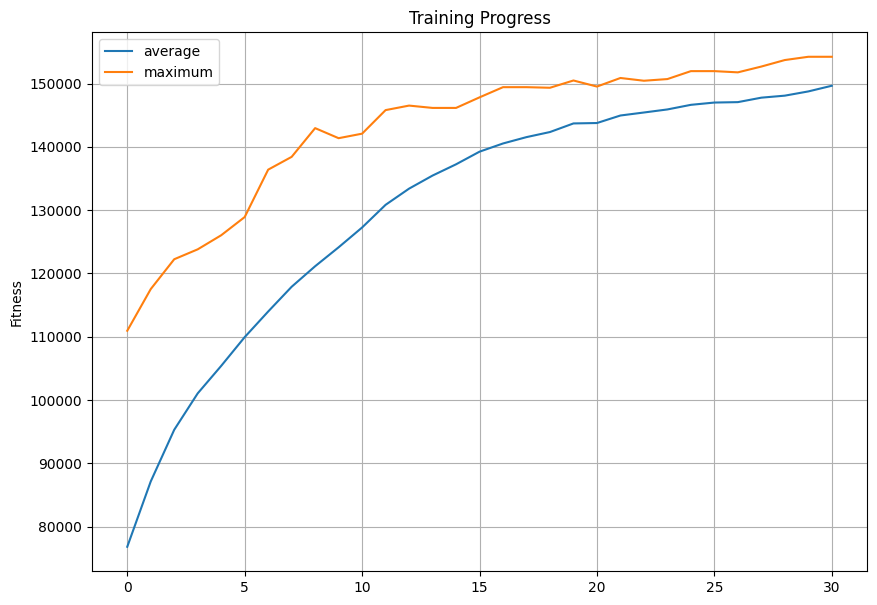

In [23]:
# ИНИЦИАЦИЯ ПАРАМЕТРОВ ГЕНЕТИКИ И ЗАПУСК АЛГОРИТМА
FlotsNumber = ActiveGRP.shape[0]
FlotsN=list(range(0, FlotsNumber+1))

# функцию оптимизации берем из файла График ГРП
# (Min - минимальное время ожидания флота ГРП, Max - максимальная накопленная добыча) 
MinMax=MinMaxcell 

# Гиперпараметры сети 
# Лучшее значение: 165876.0 (cxpb=0.5, mutpb=0.2, 500)
# Лучшая комбинация: 1221333222013001323113311333211132103312233313123112220000

# Лучшее значение: 167913.0 (cxpb=1.1522749365764187, mutpb=0.13555863750682456, 562)
# Лучшая комбинация: 1322223113023002331221122122132211203331122233231213221000
    
# Лучшее значение: 168009.0 (cxpb=0.8039690222918632, mutpb=0.10096793123263802, 651)
# Лучшая комбинация: 2132321033012302112213312321312123102223311231123132110000

populations=651             # количество собей в популяции
cxpb=0.8039690222918632     # коэф. скрещивания
mutpb=0.10096793123263802   # коэф. мутации 

# Определяем минимизацию или максимизацию
if MinMax == "Max":
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
elif MinMax == "Min":
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

SkvQuantity=gGRP.shape[0]  # количество скважин для перебора

toolbox.register("attr_int", random.choice, FlotsN)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=SkvQuantity)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=FlotsNumber, indpb=0.1)  # Изменен диапазон мутации

toolbox.register("select", tools.selTournament, tournsize=3)
# toolbox.register("select", tools.selBest)

#toolbox.register("evaluate", evaluate)
toolbox.register("evaluate", partial(evaluate, mm=MinMax))  # Или MinMax="Min" в зависимости от того, что нам нужно

# Eсли дообучаем оптимизированный график запускаем optimize_grafik_GRP
# Eсли с нуля делаем График ГРП то RunGenereate(MinMax) 
if Doobuchenie:
    flots=gGRP['FlotNumber']                     # считываем названия флотов из графика ГРП
    pop, hof, log = optimize_grafik_GRP(flots, populations, cxpb, mutpb)
else:
    # !!!!! запуск генетической сети !!!!!!
    pop, hof, log = RunGenereate(MinMax, populations, cxpb, mutpb) 
    # pop, hof, log = RunGenereate(MinMax, BestCount)             # для варианта 2 где считаем до BestCount повторний лучшего бота

print("Лучшее значение:", hof[0].fitness.values[0])
print("Лучшая комбинация:", ''.join(map(str, hof[0])))

# Сохраняем лучшего индивида и популяцию для дальнейшего дообучения если захотим
best_individual = hof[0]
saved_population = pop[:]

fn=gGRP['FlotNumber']                     # считываем названия флотов из графика ГРП


# Отображение графика обучения
gen = log.select("gen")
avg = log.select("avg")

if MinMax == "Max":
    max_ = log.select("max")
else:
    min_ = log.select("min")
    
plt.figure(figsize=(10, 7))
plt.plot(gen, avg, label="average")

if MinMax == "Max":
    plt.plot(gen, max_, label="maximum")
else:
    plt.plot(gen, min_, label="minimum")

    plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Training Progress")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# !!!! дообучаем лучшего бота если надо !!!!
best_individual=hof[0]
new_pop, new_hof, new_log = continue_training(best_individual, saved_population, cxpb, mutpb, generations=20)
best_individual=new_hof[0]
print(f" лучший бот до обучения    {''.join(map(str, hof[0]))}")
print(f" лучший бот после обучения {''.join(map(str, new_hof[0]))}")

In [24]:
# запишем лучшую комбинацию в базу
BestRezult=bestbotsave(hof[0], MinMax)
BestRezult

C:\Users\BigMan\AppData\Local\Temp\ipykernel_1700\3213355825.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gGRP["FlotNumber"].iloc[i]=FlotsName[bot[i]-1]  # обновляем номер флота для скважины gGRP["SKV"].iloc[i]
C:\Users\BigMan\AppData\Local\Temp\ipykernel_1700\3213355825.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gGRP["DateKonGRP"].iloc[i]=tempGRPend[bot[i]-1] # обновляем дату окончания ГРП для скважины gGRP["SKV"].iloc[i]
C:\Users\BigMan\AppData\Local\Temp\ipykernel_1700\3213355825.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

(154231.0,)

In [25]:
# обьедним базы для записи в excel
gGRP1=pd.concat([ActiveGRP,gGRP], axis=0)
gGRP1.shape

(61, 43)

In [26]:
# ПОДСЧЕТ КОЛИЧЕСТВА И ДЛИННЫ ПОДВЕСОК ГРП (вар3 - рабочий)

# Преобразование дат в gGRP1 в формат datetime, если это еще не сделано
gGRP1['DateGotGRP'] = pd.to_datetime(gGRP1['DateGotGRP'], errors='coerce')
gGRP1['DateKonGRP'] = pd.to_datetime(gGRP1['DateKonGRP'], errors='coerce')


# ----- задание переменных  для расета подвесок ГРП ----------#
# Список размеров NKT для цикла ['60mm', '73mm', '89mm']
sizes = ['60mm', '73mm', '89mm']

# Список границ для подсчета [1000, 2000, 3000, 3500]
limits = [1000, 2000, 3000, 3500]

# Список состояния подвески ['spusk', 'izvl', 'all','max']
priznaks = ['all']

# Список единиц измерения ['sht', 'M']
edizm = ['sht']

# коэффициент  запаса длинны подвески ГРП
Kzapas=1.2

DaysIzvlNKT=3    # количество дней на извлечение подвески после окончания ГРП
DaysZavozNKT=-2  # количество дней до даты готовности к ГРП для завоза подвески
#-------------------------------------------------------------#

# Функция для подсчета количества и длинны подвесок
def calculate_podv(df, start_date, date_column, size_column, lower_limit, upper_limit, condition):
    if condition == "<":
        filtered_df = df[(df[date_column] <= start_date) &
                         (df[size_column] > lower_limit) &
                         (df[size_column] <= upper_limit)]
    else:
        filtered_df = df[(df[date_column] == start_date) &
                         (df[size_column] > lower_limit) &
                         (df[size_column] <= upper_limit)]

    
    count = filtered_df.shape[0]             # Количество подвесок
    length = filtered_df[size_column].sum()  # Общая длина подвесок
    
    return count, length

# Преобразование в числовой формат, некорректные значения заменяются на NaN
for size in sizes:
    gGRP1[size] = pd.to_numeric(gGRP1[size], errors='coerce')  

# Создание новых колонок для упрощения вычислений
for size in sizes:
    gGRP1[f'{size}_adjusted'] = gGRP1[size] * Kzapas

# Вычисление диапазонов дат для определения статуса подвесок
gGRP1['DateZavozPodv'] = gGRP1['DateGotGRP'] + timedelta(days=DaysZavozNKT)
gGRP1['DateVivozPodv'] = gGRP1['DateKonGRP'] + timedelta(days=DaysIzvlNKT + 1)


# создаем список из дат от начала до окончания графика ГРП
GrDates = pd.date_range(FirstDate, LastDate) 
results_list=[]                              

# цикл по датам Графика ГРП
for grdate in GrDates:

    respodv = {}
    # цикл по типоразмерам пордвесок
    for size in sizes:
        # цикл по длиннам подвесок
        for i, limit in enumerate(limits):
            lower_limit = 0 if i == 0 else limits[i-1]
            upper_limit = limit
            size_column = f'{size}_adjusted'

            # Подсчет для спущенных подвесок
            count_sp, length_sp = calculate_podv(gGRP1, grdate,'DateZavozPodv', size_column, lower_limit, upper_limit, "<")
            respodv[f'{size}_{upper_limit}_sp_count'] = count_sp
            respodv[f'{size}_{upper_limit}_sp_length'] = length_sp

            # Подсчет для извлеченных подвесок
            count_iz, length_iz = calculate_podv(gGRP1, grdate, 'DateVivozPodv', size_column, lower_limit, upper_limit, "<")
            respodv[f'{size}_{upper_limit}_iz_count'] = count_iz
            respodv[f'{size}_{upper_limit}_iz_length'] = length_iz

            respodv[f'{size}_{upper_limit}_All_count'] = count_sp - count_iz
            respodv[f'{size}_{upper_limit}_All_length'] = length_sp - length_iz
            
    
    # Добавление результатов в список
    results_list.append(pd.DataFrame(respodv, index=[grdate]))

# Преобразование результатов в датафрейм
results_df = pd.concat(results_list)
    
# удалаем временные столбцы из gGRP1
coldrop=[]
for size in sizes:
    coldrop.append(f'{size}_adjusted')
coldrop.extend(['DateZavozPodv', 'DateVivozPodv'])
gGRP1 = gGRP1.drop(columns=coldrop)   


# Подсчет максимально необходимого количества подвесок ГРП
max_values = results_df.max() 

msgPodv=[]
msgPodv.append("Максимальное количество подвесок понадобится для выполнения графика ГРП:")

# выводим в список только данные из столбцов которые содержат All и count или All и length
max_values_count = max_values[max_values.index.str.contains('All') & max_values.index.str.contains('count')]
max_values_length = max_values[max_values.index.str.contains('All') & max_values.index.str.contains('length')]

i = 0
for i in range(len(max_values_count)):

    podvname = max_values_count.index[i]
    podvcount=max_values_count[i]
    podvlength=max_values_length[i]
    if podvcount!=0:
        msgPodv.append(f"{podvname[:9]}  = {podvcount} шт / {int(podvlength)} м")

# отбираем только нужные столбцы с расчетом подвесок ГРП для сохранения в графике ГРП
podvcolumns=max_values[max_values.index.str.contains('All') & max_values.index.str.contains('count')].index
PodVdf=results_df[podvcolumns]

C:\Users\BigMan\AppData\Local\Temp\ipykernel_1700\1786444500.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  podvcount=max_values_count[i]
C:\Users\BigMan\AppData\Local\Temp\ipykernel_1700\1786444500.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  podvlength=max_values_length[i]


In [27]:
# сортируем базу перед записью в excel и  удалем 0 из названия флотов 

# удалем названия флотов где дата окончания ГРП пустая
gGRP1.loc[gGRP1['DateKonGRP'].isna(), 'FlotNumber'] = np.nan

# удаляем 0 из FlotNumber для того чтобы можно было этот  файл использовать для дообучения
# (c 0 в модуле поиска действующих флотов выходит ошибка на функции группировки)
gGRP1.FlotNumber=gGRP1.FlotNumber.replace(0,'')

# сортируем базу преред записью в excel
gGRP1=gGRP1.sort_values(['FlotNumber', 'DateKonGRP'], ascending=(True, True ))

print(gGRP1.shape)
gGRP1.head(10)

(61, 43)


,CDNG,MEST,SKV,KUST,PLAST,KATEG,2Agabarit,DopRaboti,Kvaznost,Qn_nak_ozid,...,Tn_prop_stad,Time_stad,TimeGRP,14,15,16,17,18,FlotNumber,QnMAX
4,3,Вахское,557,41,Б16-20,нефт,1.0,2.0,1.0,NaN,...,30,22,1,NaN,NaN,NaN,NaN,NaN,ПС-1,651.0
41,1,Советское,642,21,БВ0,нефт,NaN,NaN,1.0,870.0,...,5,30,4,NaN,NaN,NaN,NaN,NaN,ПС-1,NaN
7,2,Советское,2225,234,АВ1,нефт,1.0,NaN,1.0,840.0,...,7,30,3,NaN,NaN,NaN,NaN,NaN,ПС-1,NaN
45,3,Северное,506,1А,Б9,нефт,NaN,NaN,5.0,1580.0,...,50,23,4,NaN,NaN,NaN,NaN,NaN,ПС-1,NaN
46,3,Вахское,219,18,Ю1/1+2,нефт,NaN,NaN,1.0,546.0,...,75,31,1,NaN,NaN,NaN,NaN,NaN,ПС-1,NaN
9,2,Нижневартовское,1152,40,АВ1,нефт,NaN,NaN,5.0,2556.0,...,5,12,4,NaN,NaN,NaN,NaN,NaN,ПС-1,NaN
30,7,Оленье,627,29,Ю1,нефт,NaN,NaN,5.0,910.0,...,20,21,4,NaN,NaN,NaN,NaN,NaN,ПС-1,NaN
31,7,Катыльгинское,582,25,Ю1(1+2+м),нефт,NaN,NaN,1.0,832.0,...,100,33,1,NaN,NaN,NaN,NaN,NaN,ПС-1,NaN
32,7,Катыльгинское,788,25,Ю1(1+2+м),нефт,NaN,NaN,1.0,819.0,...,60,26,1,NaN,NaN,NaN,NaN,NaN,ПС-1,NaN
33,9,Карайское,1307Б,8,Ю1,нефт,NaN,NaN,5.0,2016.0,...,20,21,6,NaN,NaN,NaN,NaN,NaN,ПС-1,NaN


In [28]:
# ЗАПИСЬ ОБУЧЕННОЙ БАЗЫ  В EXCEL

file_path = copy_file

# Загрузите файл
book = openpyxl.load_workbook(file_path)

# Получите нужный лист
sheet = book['График ГРП']

# Обновите значения на листе
for idx, r in enumerate(dataframe_to_rows(gGRP1, index=False, header=False), start=skiprs+2):
    for c_idx, value in enumerate(r, 2):  # начните с 2, чтобы начать с колонки B
        sheet.cell(row=idx, column=c_idx, value=value)

#---- копируем формулы расчета даты начала окончания ЗР ГРП, и накопленного дебита на листе График ГРП-----
# Получаем формулы из ячеек
formula_DateNachZr = sheet['X11'].value  # формула дата начала ЗР ГРП
formula_DateKonZr = sheet['Y11'].value   # формула дата окончания ЗР ГРП
formula_Qnak = sheet['U11'].value        # формула расчет накопленной добычи

#количество строк с непустыми значениями флотов для копирования формул
# countrows=gGRP1.FlotNumber.notnull().sum() 
countrows=gGRP1.shape[0]

# Копируем формулы в диапазон от 19 строки до окончания списка
for row in range(skiprs+2, skiprs + 2 + countrows):
    # меняем номера строк в формулах для корректной работы 
    new_formula_DateNachZr = formula_DateNachZr.replace("11", f"{row}")
    new_formula_DateKonZr = formula_DateKonZr.replace("11", f"{row}")
    new_formula_Qnak = formula_Qnak.replace("11", f"{row}")        
    
    sheet.cell(row=row, column=24, value=new_formula_DateNachZr)  # Копирование формулы даты начала ЗР ГРП в столбец X
    sheet.cell(row=row, column=25, value=new_formula_DateKonZr)   # Копирование формулы даты окончания ЗР ГРП в столбец Y
    sheet.cell(row=row, column=21, value=new_formula_Qnak)   # Копирование формулы расчета накопленного дебита столбец U
#---------------------------------------------------------------------------------------------------------------    
       
# записываем график расчета подвесок в отдельный лист
# sheet = book['подвески']
sheet1 = book['подвески1']

# # # Обновите значения на листе
# for idx, r in enumerate(dataframe_to_rows(PodvGRPgrapf, index=False, header=False), start=2):
#     for c_idx, value in enumerate(r, 2):  # начните с 2, чтобы начать с колонки B
#         sheet.cell(row=idx, column=c_idx, value=value)

# Обновите значения на листе
for idx, r in enumerate(dataframe_to_rows(PodVdf, index=False, header=True), start=1):
    for c_idx, value in enumerate(r, 2):  # начните с 2, чтобы начать с колонки B
        sheet1.cell(row=idx, column=c_idx, value=value)

# добавляем вниз листа данные по необходимому количеству подвесок
for index, item in enumerate(msgPodv, start=1):
    sheet1.cell(row=idx +2 + index, column=1).value = item
        
# Сохраните изменения
print("\nСохраняем файл: ",file_path)
book.save(file_path)
book.close()


Сохраняем файл:  ./График_ГРП_(оптимизированный).xlsx


In [30]:
GTMriteFile (copy_file)

Читаем файл  ./График_ГРП_(оптимизированный).xlsx
Сохраняем файл:  ./ГТМ_УДНГ_ГРП_(оптимизированный).xlsx
